In [14]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata
import gzip

from platform import python_version
print(python_version()) 

3.10.2


The goal of this preprocessing is to recreate what was done by Stephenson et al on the haniffa_processed dataset in
https://www.nature.com/articles/s41591-021-01329-2#data-availability.

Quality control, normalization, embedding and clustering
Combined raw data from the three centers was filtered to remove cells that expressed fewer than 200 genes and >10% mitochondrial reads. Data were normalized (scanpy: normalize_total), log + 1 corrected (scanpy: log1p) and HVGs identified using the Seurat vst algorithm (scanpy: highly_variable_genes). Harmony was used to adjust PCs by sample ID and used to generate the neighborhood graph and embedded using UMAP. Clustering was performed using the Leiden algorithm with an initial resolution of 3. For initial clustering, differentially expressed genes were calculated using the Wilcoxon rank-sum test.

In [8]:
guo_df = pd.read_csv('/Users/parkersimpson/CMU/02710/FinalProject/data/GSE99254_NSCLC.TCell.S12346.count.txt.gz',\
                     compression='gzip', delimiter='\t')

In [20]:
guo_df.astype({'geneID':'int64'})

guodata = anndata.AnnData(X=guo_df.iloc[1:,2:], obs=guo_df.iloc[1:,1].to_frame() , var=guo_df.iloc[0,2:].to_frame())
guodata

/var/folders/xz/mm3vvhjj04d4mw0zpnmr8k400000gn/T/ipykernel_45169/1114344972.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  guodata = anndata.AnnData(X=guo_df.iloc[1:,2:], obs=guo_df.iloc[1:,1].to_frame() , var=guo_df.iloc[0,2:].to_frame())
/Users/parkersimpson/CMU/02710/compgenomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 23458 × 12346
    obs: 'symbol'
    var: 0

/Users/parkersimpson/CMU/02710/compgenomics/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


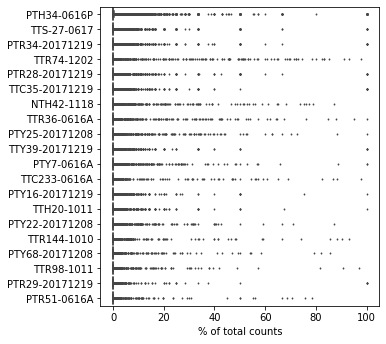

In [24]:
# Plot the top 20 genes with the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(guodata, n_top=20)

In [27]:
sc.pp.filter_cells(guodata, min_genes=200)

In [30]:
guodata.var['mt']= guodata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(guodata, qc_vars=['mt'],percent_top=None,log1p=False, inplace=True)

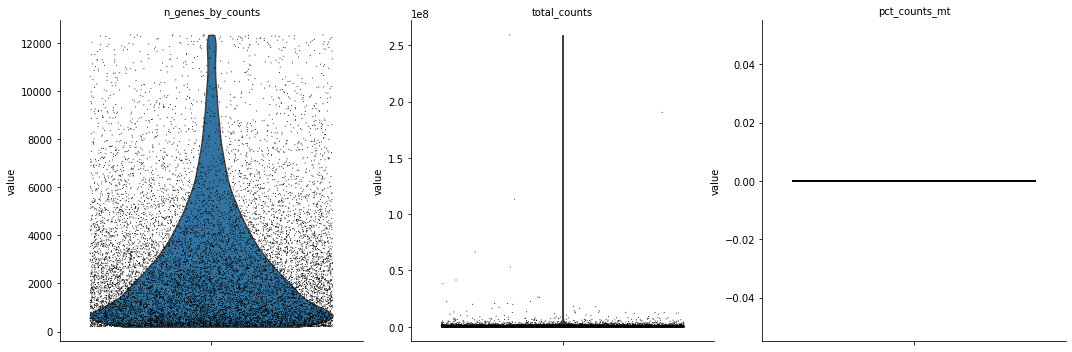

In [32]:
sc.pl.violin(guodata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

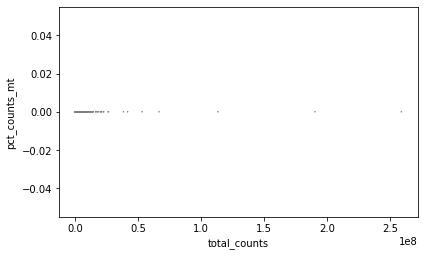

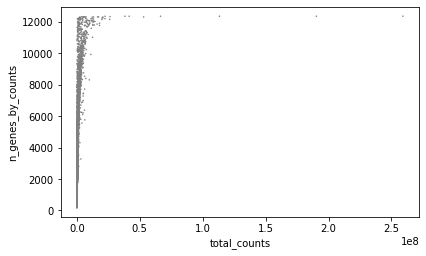

In [33]:
sc.pl.scatter(guodata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(guodata, x='total_counts', y='n_genes_by_counts')

In [34]:
guodata = guodata[guodata.obs.n_genes_by_counts < 2500, :]
guodata = guodata[guodata.obs.pct_counts_mt < 5, :]

In [35]:
sc.pp.normalize_total(guodata)

/Users/parkersimpson/CMU/02710/compgenomics/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


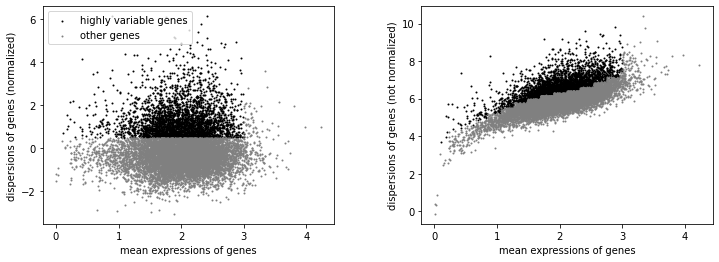

In [36]:
sc.pp.log1p(guodata)
sc.pp.highly_variable_genes(guodata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(guodata)